# Predicting Default Probability using XGBoost

XGBoost, being a gradient boosting framework for trees, does not require its users to make many of the strict assumptions that are necessary for traditional statistical models. However, there are a few considerations and best practices:

Quality Data: While XGBoost can handle missing values internally, providing quality, relevant features is crucial for building an effective model. We will check missing values (including zero values) later.

Scale of Features: Gradient boosting methods, including XGBoost, are generally scale-invariant, meaning feature scaling is not a strict requirement. Some studies showed that there is no difference between the model with and without feature scale. We will skip this step.

Outliers: XGBoost can be sensitive to outliers in the dataset. Handling outliers appropriately can improve model robustness and performance. However, iIn an XGBoost model, if there are outliers in the independent variables, these outliers don't typically disrupt the model's performance. This is because XGBoost, like other tree-based models, makes decisions by splitting data at certain points to make groups more similar to each other. It doesn't matter how far apart data points are from each other; the model just looks at whether data points fall on one side or the other of these splits. Since outliers are extreme values that don't fit well into either group, they usually don't affect where these splits happen. Therefore, outliers don't directly influence the model's decisions, ensuring that the presence of outliers doesn't decrease the model's ability to organize the data effectively.

Data Cardinality: For categorical variables with a high number of categories (high cardinality), consider encoding strategies to maintain efficiency and effectiveness of the model. This issue will be address using One Hot Encoding.

# Steps involved

1. Importing Libraries and Setting Meta Data
2. Prepare Data for Modeling
   
    2.1. Split Table into Dependent and Independent Variables
   
    2.2. One-Hot Encoding for Categorical Predictors
   
    2.3. Split Data into Training and Testing Sets
3. Building XGBoost Model
   
    3.1. Initial Model without Hyperparameter Tuning
   
    3.2. Optimizing Parameters using Cross-Validation and GridSearchCV
   
    3.3. Optimal XGBoost Model with Tuned Hyperparameters
   
4. Model Evaluation
   
    4.1. Evaluating Model with Threshold = 0.5
   
    4.2. Threshold to keep FNR < 10%
   
    4.3 Threshold to balance FNR = 2xFPR
   
6. Conclusion

## 1. Importing Libraries and setting meta data

In [162]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import xlrd
import numpy as np # calculate the mean and standard deviation
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay # creates and draws a confusion matrix
import warnings
warnings.filterwarnings('ignore')

seed = 110 #Initialize a random seed for reproducible results.

pd.options.display.max_columns = None

In [163]:
#Load clean data
df = pd.read_excel('credit_data_clean.xlsx')
df.head()

,Unnamed: 0,CHK_ACCT,DURATION,HISTORY,AMOUNT,SAV_ACCT,EMPLOYMENT,INSTALL_RATE,CO-APPLICANT,GUARANTOR,PRESENT_RESIDENT,REAL_ESTATE,PROP_UNKN_NONE,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,DEFAULT,LIFE_STATUS,LOAN_PURPOSE
0,0,0,6,4,1169,4,4,4,0,0,4,1,0,67,0,0,1,2,2,1,1,0,0,2,4
1,1,1,48,2,5951,0,2,2,0,0,2,1,0,22,0,0,1,1,2,1,0,0,1,0,4
2,2,3,12,4,2096,0,3,2,0,0,3,1,0,49,0,0,1,1,1,2,0,0,0,2,5
3,3,0,42,2,7882,0,3,2,0,1,4,0,0,45,0,0,0,1,2,2,0,0,0,2,3
4,4,0,24,3,4870,0,2,3,0,0,4,0,1,53,0,0,0,2,2,2,0,0,1,2,1


In [164]:
df = df.iloc[:,1:]
df.head()

,CHK_ACCT,DURATION,HISTORY,AMOUNT,SAV_ACCT,EMPLOYMENT,INSTALL_RATE,CO-APPLICANT,GUARANTOR,PRESENT_RESIDENT,REAL_ESTATE,PROP_UNKN_NONE,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,DEFAULT,LIFE_STATUS,LOAN_PURPOSE
0,0,6,4,1169,4,4,4,0,0,4,1,0,67,0,0,1,2,2,1,1,0,0,2,4
1,1,48,2,5951,0,2,2,0,0,2,1,0,22,0,0,1,1,2,1,0,0,1,0,4
2,3,12,4,2096,0,3,2,0,0,3,1,0,49,0,0,1,1,1,2,0,0,0,2,5
3,0,42,2,7882,0,3,2,0,1,4,0,0,45,0,0,0,1,2,2,0,0,0,2,3
4,0,24,3,4870,0,2,3,0,0,4,0,1,53,0,0,0,2,2,2,0,0,1,2,1


## 2. Prepare Data for Modeling

### 2.1 Split Table into Dependent and Independent Variables

In [165]:
X = df.drop('DEFAULT', axis=1).copy()
Y= df['DEFAULT'].copy()

In [166]:
X.head()

,CHK_ACCT,DURATION,HISTORY,AMOUNT,SAV_ACCT,EMPLOYMENT,INSTALL_RATE,CO-APPLICANT,GUARANTOR,PRESENT_RESIDENT,REAL_ESTATE,PROP_UNKN_NONE,AGE,OTHER_INSTALL,RENT,OWN_RES,NUM_CREDITS,JOB,NUM_DEPENDENTS,TELEPHONE,FOREIGN,LIFE_STATUS,LOAN_PURPOSE
0,0,6,4,1169,4,4,4,0,0,4,1,0,67,0,0,1,2,2,1,1,0,2,4
1,1,48,2,5951,0,2,2,0,0,2,1,0,22,0,0,1,1,2,1,0,0,0,4
2,3,12,4,2096,0,3,2,0,0,3,1,0,49,0,0,1,1,1,2,0,0,2,5
3,0,42,2,7882,0,3,2,0,1,4,0,0,45,0,0,0,1,2,2,0,0,2,3
4,0,24,3,4870,0,2,3,0,0,4,0,1,53,0,0,0,2,2,2,0,0,2,1


Now that we have split the data frame into two pieces, X, which contains the data we will use to make, or predict, classifications, and y, which contains the known classifications in our training dataset, we need to take a closer look at the variables in X

### 2.2 One-Hot Encoding for Categorical Predictors

In [167]:
X.dtypes

CHK_ACCT            int64
DURATION            int64
HISTORY             int64
AMOUNT              int64
SAV_ACCT            int64
EMPLOYMENT          int64
INSTALL_RATE        int64
CO-APPLICANT        int64
GUARANTOR           int64
PRESENT_RESIDENT    int64
REAL_ESTATE         int64
PROP_UNKN_NONE      int64
AGE                 int64
OTHER_INSTALL       int64
RENT                int64
OWN_RES             int64
NUM_CREDITS         int64
JOB                 int64
NUM_DEPENDENTS      int64
TELEPHONE           int64
FOREIGN             int64
LIFE_STATUS         int64
LOAN_PURPOSE        int64
dtype: object

In [168]:
X.columns.tolist()

['CHK_ACCT',
 'DURATION',
 'HISTORY',
 'AMOUNT',
 'SAV_ACCT',
 'EMPLOYMENT',
 'INSTALL_RATE',
 'CO-APPLICANT',
 'GUARANTOR',
 'PRESENT_RESIDENT',
 'REAL_ESTATE',
 'PROP_UNKN_NONE',
 'AGE',
 'OTHER_INSTALL',
 'RENT',
 'OWN_RES',
 'NUM_CREDITS',
 'JOB',
 'NUM_DEPENDENTS',
 'TELEPHONE',
 'FOREIGN',
 'LIFE_STATUS',
 'LOAN_PURPOSE']

In [169]:
numeric = ['DURATION', 'AMOUNT', 'AGE']
categorical = df.drop(columns=[*numeric,"DEFAULT"]).columns
categorical

Index(['CHK_ACCT', 'HISTORY', 'SAV_ACCT', 'EMPLOYMENT', 'INSTALL_RATE',
       'CO-APPLICANT', 'GUARANTOR', 'PRESENT_RESIDENT', 'REAL_ESTATE',
       'PROP_UNKN_NONE', 'OTHER_INSTALL', 'RENT', 'OWN_RES', 'NUM_CREDITS',
       'JOB', 'NUM_DEPENDENTS', 'TELEPHONE', 'FOREIGN', 'LIFE_STATUS',
       'LOAN_PURPOSE'],
      dtype='object')

In [170]:
X_encoded = pd.get_dummies(X, columns=categorical)
X_encoded

,DURATION,AMOUNT,AGE,CHK_ACCT_0,CHK_ACCT_1,CHK_ACCT_2,CHK_ACCT_3,HISTORY_0,HISTORY_1,HISTORY_2,HISTORY_3,HISTORY_4,SAV_ACCT_0,SAV_ACCT_1,SAV_ACCT_2,SAV_ACCT_3,SAV_ACCT_4,EMPLOYMENT_0,EMPLOYMENT_1,EMPLOYMENT_2,EMPLOYMENT_3,EMPLOYMENT_4,INSTALL_RATE_1,INSTALL_RATE_2,INSTALL_RATE_3,INSTALL_RATE_4,CO-APPLICANT_0,CO-APPLICANT_1,GUARANTOR_0,GUARANTOR_1,PRESENT_RESIDENT_1,PRESENT_RESIDENT_2,PRESENT_RESIDENT_3,PRESENT_RESIDENT_4,REAL_ESTATE_0,REAL_ESTATE_1,PROP_UNKN_NONE_0,PROP_UNKN_NONE_1,OTHER_INSTALL_0,OTHER_INSTALL_1,RENT_0,RENT_1,OWN_RES_0,OWN_RES_1,NUM_CREDITS_1,NUM_CREDITS_2,NUM_CREDITS_3,NUM_CREDITS_4,JOB_0,JOB_1,JOB_2,JOB_3,NUM_DEPENDENTS_1,NUM_DEPENDENTS_2,TELEPHONE_0,TELEPHONE_1,FOREIGN_0,FOREIGN_1,LIFE_STATUS_0,LIFE_STATUS_1,LIFE_STATUS_2,LIFE_STATUS_3,LOAN_PURPOSE_0,LOAN_PURPOSE_1,LOAN_PURPOSE_2,LOAN_PURPOSE_3,LOAN_PURPOSE_4,LOAN_PURPOSE_5,LOAN_PURPOSE_6
0,6,1169,67,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,True,False,True,False,False,False,False,True,False,True,True,False,True,False,True,False,False,True,False,True,False,False,False,False,True,False,True,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,False
1,48,5951,22,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,True,True,False,True,False,True,False,False,True,True,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,False,False,True,False,False
2,12,2096,49,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False,False,True,True,False,True,False,True,False,False,True,True,False,False,False,False,True,False,False,False,True,True,False,True,False,False,False,True,False,False,False,False,False,False,True,False
3,42,7882,45,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False
4,24,4870,53,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,False,True,True,False,False,True,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False,True,True,False,True,False,False,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,31,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,True,False,True,True,False,True,False,True,False,False,True,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False,False
996,30,3857,40,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,True,False,True,False,True,False,False,True,True,False,False,False,False,False,False,True,True,False,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False
997,12,804,38,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,Tru

In [171]:
print(X_encoded.dtypes.unique())
X_encoded.dtypes

[dtype('int64') dtype('bool')]


DURATION          int64
AMOUNT            int64
AGE               int64
CHK_ACCT_0         bool
CHK_ACCT_1         bool
                  ...  
LOAN_PURPOSE_2     bool
LOAN_PURPOSE_3     bool
LOAN_PURPOSE_4     bool
LOAN_PURPOSE_5     bool
LOAN_PURPOSE_6     bool
Length: 69, dtype: object

### 2.3 Split Data into Training and Testing Sets

In [172]:
#Check if the dataset is balanced or not
sum(Y)/len(Y) 

0.3

So we see that only 30% of the people in the dataset defaulted. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who defaulted in both the training set and the testing set.

In [173]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, random_state= seed, stratify=Y)
print(sum(Y_train)/len(Y_train), sum(Y_test)/len(Y_test))

0.3 0.3


## 3. Building XGBoost Model

### 3.1. Initial Model without Hyperparameter Tuning

In [174]:
xgb_org = xgb.XGBClassifier(objective='binary:logistic',missing = np.nan,
                            seed=seed)
xgb_org.fit(X_train, Y_train,verbose = True, early_stopping_rounds = 10 #stop building trees when they no longer improve the situation
           ,eval_metric = 'auc', eval_set = [(X_test,Y_test)])

[0]	validation_0-auc:0.69935
[1]	validation_0-auc:0.74011
[2]	validation_0-auc:0.74194
[3]	validation_0-auc:0.77124
[4]	validation_0-auc:0.76149
[5]	validation_0-auc:0.75821
[6]	validation_0-auc:0.76190
[7]	validation_0-auc:0.76640
[8]	validation_0-auc:0.76686
[9]	validation_0-auc:0.77051
[10]	validation_0-auc:0.78118
[11]	validation_0-auc:0.78392
[12]	validation_0-auc:0.78179
[13]	validation_0-auc:0.77653
[14]	validation_0-auc:0.77554
[15]	validation_0-auc:0.77410
[16]	validation_0-auc:0.77013
[17]	validation_0-auc:0.77227
[18]	validation_0-auc:0.77356
[19]	validation_0-auc:0.77585
[20]	validation_0-auc:0.77623
[21]	validation_0-auc:0.77768


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

The initial XGBoost model uses 12 trees




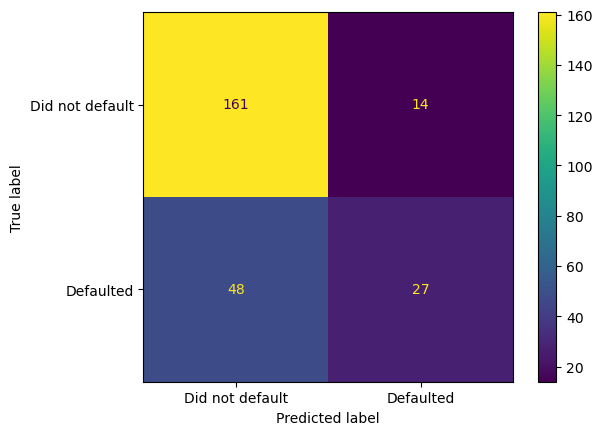

In [175]:
ConfusionMatrixDisplay.from_estimator(xgb_org,
                                      X_test,
                                      Y_test,
                                      values_format='d',
                                      display_labels=["Did not default", "Defaulted"])

We can show that 188 instances were correctly classified (161 True Negatives & 27 True Positves), associated with 75%. That's quite good. However,out of 75 people that defaulted, only 27 (36%) were correctly classified. Part of the problem is that our data is imbalanced. Because defaulting on loans costs the company a lot of money, we would like to capture more of the people that defaulted.

That's why we need to use Cross Validation and Hyperparameter tuning to improve predictions and prevent overfitting.

### 3.2. Optimizing Parameters using Cross-Validation and GridSearchCV

In [176]:
# ROUND 1
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'gamma': [0, 0.25, 0.5, 0.75, 1.0],
    'reg_lambda': [0, 1.0, 5, 10.0],
    }


# ## NOTE: To speed up cross validiation, and to further prevent overfitting.
# ## We are only using a random subset of the data (90%) and are only
# ## using a random subset of the features (columns) (50%) per tree.

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                seed=seed,
                                subsample=0.9,
                                colsample_bytree=0.5,
                               scale_pos_weight = 3), #NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs = 10,
    cv = 5
)

optimal_params.fit(X_train, 
                   Y_train, 
                   early_stopping_rounds=10,                
                   eval_metric='auc',
                   eval_set=[(X_test, Y_test)],
                   verbose=False)
best_params = optimal_params.best_params_
print(optimal_params.best_params_)

{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 5}


### 3.3 Optimal XGBoost Model with Tuned Hyperparameters

In [177]:
xgb_optimal = xgb.XGBClassifier(seed=seed,
                            objective='binary:logistic',
                            **best_params,
                            scale_pos_weight = 3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            ## the next two arguments set up early stopping:
                            eval_metric='auc',
                            early_stopping_rounds=10)
                        
xgb_optimal.fit(X_train, 
            Y_train, 
            verbose=True, 
            eval_set=[(X_test, Y_test)])

[0]	validation_0-auc:0.68514
[1]	validation_0-auc:0.72232
[2]	validation_0-auc:0.74457
[3]	validation_0-auc:0.75863
[4]	validation_0-auc:0.75989
[5]	validation_0-auc:0.76190
[6]	validation_0-auc:0.76693
[7]	validation_0-auc:0.77006
[8]	validation_0-auc:0.77021
[9]	validation_0-auc:0.77638
[10]	validation_0-auc:0.77714
[11]	validation_0-auc:0.77310
[12]	validation_0-auc:0.77402
[13]	validation_0-auc:0.77288
[14]	validation_0-auc:0.77295
[15]	validation_0-auc:0.76990
[16]	validation_0-auc:0.76846
[17]	validation_0-auc:0.76777
[18]	validation_0-auc:0.76819
[19]	validation_0-auc:0.76480
[20]	validation_0-auc:0.76221


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

The after-tuning XGBoost model uses 11 trees

## 4. Choosing an optimal threshold

### 4.1. Evaluating Model with Threshold = 0.5

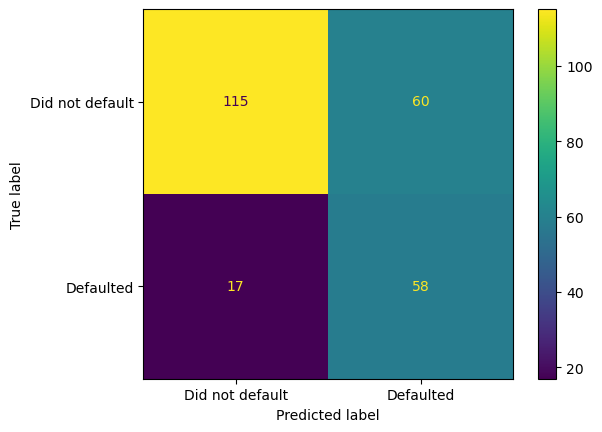

In [178]:
ConfusionMatrixDisplay.from_estimator(xgb_optimal,
                                      X_test,
                                      Y_test,
                                      values_format='d',
                                      display_labels=["Did not default", "Defaulted"])

Now we can see that 182 people were correct classified (including 160 non-defaulted ones and 22 defaulted ones), associated with 72.8% which is lower than the pre tuning model but it is acceptable and will keep us from overfitting.

However, there is only 22 out of 75 defaulted people were correctly classified, associated with 29.3%.

In credit industry, such as in this case, we are more concerned with minimizing the wrong classification of True (Defaulted) as False (Non-Defaulted). So, we are more concerned about Lowering False Negative Rate

The previous model shows that29.3% of people that are defaulted were wrongly classified as non-defaulted. Assume that we aim to lower the false negative rate to below 10%. Let's determine the appropriate threshold to achieve this.

First let's create some functions to get the threshold.

### 4.2. Threshold to keep FNR < 10%

In [179]:
Y_pred = xgb_optimal.predict_proba(X_test)[:,[1]]
Y_pred[:10]

array([[0.6377564 ],
       [0.64065635],
       [0.41706654],
       [0.37118313],
       [0.46235028],
       [0.5871716 ],
       [0.6300408 ],
       [0.40894362],
       [0.47112295],
       [0.359155  ]], dtype=float32)

In [180]:
def select_threshold_fnr(fnr,thresholds,target_fnr):
    """
    returns the threshold value for the target_fnr and idx value
    """
    #search for value >=target_fnr from end of fnr
    target_fnr=target_fnr
    idx=0
    fn=fnr[0]
    while fn >=target_fnr:
        idx+=1
        fn=fnr[idx]

    #now idx is for value to right of target_fnr
    left_fnr=fnr[idx-1]
    right_fnr=fnr[idx]
    left_threshold=thresholds[idx-1]
    right_threshold=thresholds[idx]

    #find threshold corresponding to target_fnr by linear approximation
    ratio=(left_fnr-target_fnr)/(left_fnr-right_fnr)
    target_thresh=left_threshold-(ratio*(left_threshold-right_threshold))
    if (left_fnr-target_fnr)<=(target_fnr-right_fnr):
        best_idx=idx-1
    else:
        best_idx=idx
    return target_thresh

def thresh_pred(probs,threshold):
    """
    Takes in probabilites predicted by model and threshold value
    Return array of classification predictions based on the threshold
    """
    predictions=np.where(probs>threshold,1,0)
    return predictions

In [181]:
fpr,tpr,thresholds=roc_curve(Y_test,Y_pred)
fnr=1-tpr
target_fpr = 0.1
thresh = select_threshold_fnr(fnr,thresholds,target_fpr)
thresh

0.43676918745040894

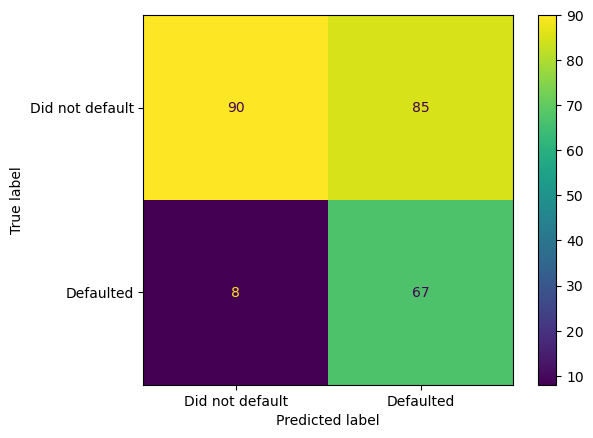

In [182]:
cm1 = confusion_matrix(Y_test, thresh_pred(Y_pred,thresh))
cm_display1 = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = ["Did not default", "Defaulted"])

cm_display1.plot()
plt.show()

We can observe that only 8 out of the 75 people who defaulted were incorrectly classified. However, this adjustment also resulted in a significant rise in the number of people who didn't default being labeled as defaulted.Therefore, setting the threshold to 0.436 means we'll likely overlook many good customers.

Let's consider another scenario to strike a balance between overlooking potential good customers and identifying risky ones.

Suppose historically, offering credit to a bad customer averagely cost us USD30,000 loss and offering credit to a good customer will bring an average profit of USD15,000

Thus, the financial impact of a false negative is twice that of a false positive.

While cost analysis can be complex and depends on various factors, it's common for the consequences of false negatives to be more severe than those of false positives. In this scenario, given that a false negative is twice as costly as a false positive, let’s determine a threshold that aligns with this premise that aligns with this premise.

### 4.3 Threshold to balance FNR = 2xFPR

In [183]:
def find_threshold(fnr, fpr, thresholds, goal):
    
    fn_to_fp_rate = fnr/fpr
    
    # Initialize the closest index and minimum difference
    closest_index = None
    min_diff = abs(fn_to_fp_rate - goal)
    min_diff_idx = np.argmin(min_diff)
    return thresholds[min_diff_idx]

rate_goal = 2
threshold = find_threshold(fnr, fpr, thresholds,rate_goal)
print("Threshold for FNP = 2xFPR:", threshold)


Threshold for FNP = 2xFPR: 0.58234066


In [184]:
cm2 = confusion_matrix(Y_test, thresh_pred(Y_pred,threshold))


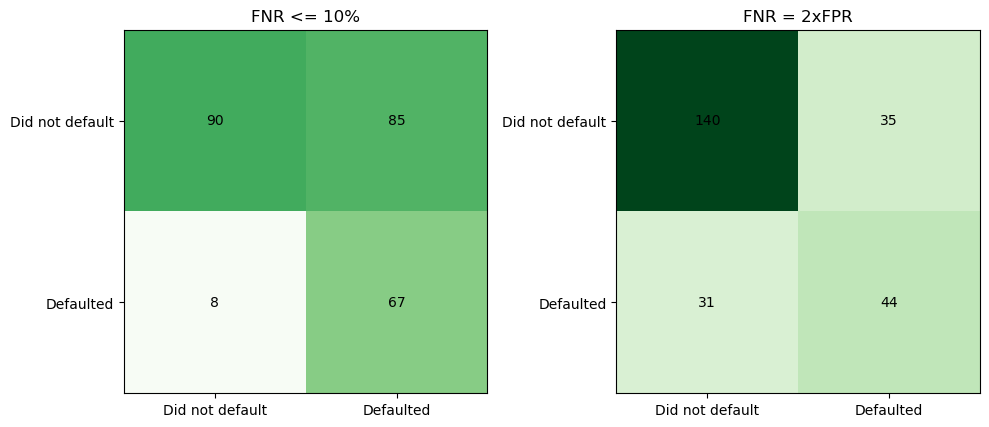

In [185]:
# Normalize confusion matrices for mutual color measure
cm1_normalized = cm1 / cm1.sum()
cm2_normalized = cm2 / cm2.sum()

# Determine overall min and max for consistent color scaling
vmin = min(cm1_normalized.min(), cm2_normalized.min())
vmax = max(cm1_normalized.max(), cm2_normalized.max())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted to 2 subplots instead of 3

# Function to annotate the cells with the true values
def annotate_cells(ax, cm):
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")

# Plot the first confusion matrix
img1 = axes[0].imshow(cm1_normalized, interpolation='nearest', cmap='Greens', vmin=vmin, vmax=vmax)
axes[0].set_title('FNR <= 10%')
axes[0].set_xticks(np.arange(len(["Did not default", "Defaulted"])))
axes[0].set_yticks(np.arange(len(["Did not default", "Defaulted"])))
axes[0].set_xticklabels(["Did not default", "Defaulted"])
axes[0].set_yticklabels(["Did not default", "Defaulted"])
annotate_cells(axes[0], cm1)  # Annotate with true values

# Plot the second confusion matrix
img2 = axes[1].imshow(cm2_normalized, interpolation='nearest', cmap='Greens', vmin=vmin, vmax=vmax)
axes[1].set_title('FNR = 2xFPR')
axes[1].set_xticks(np.arange(len(["Did not default", "Defaulted"])))
axes[1].set_yticks(np.arange(len(["Did not default", "Defaulted"])))
axes[1].set_xticklabels(["Did not default", "Defaulted"])
axes[1].set_yticklabels(["Did not default", "Defaulted"])
annotate_cells(axes[1], cm2)  # Annotate with true values

plt.tight_layout()
plt.show()

## 5. Conclusion
When we delve into the world of credit risk modeling, one of the key decisions we face is setting the right threshold. Think of this threshold like the setting on a metal detector. Set it too high, and you might miss some items; too low, and you'll be stopping every second person.

In our case, the 'items' are potential credit risks, and the 'people' are our customers. If we're very cautious, we might set our threshold to be very sensitive, catching as many true risks as possible. This is like having a metal detector that beeps at the smallest hint of metal — ensuring security but possibly leading to delays and inconveniences for many.

On the other hand, if we're willing to take on a bit more risk, we can set the threshold lower. This would reduce the chances of falsely flagging customers as risks, leading to a smoother experience for everyone, but it might let a few more risky loans slip through the cracks.

The key question is, what's more important for your business? Ensuring that almost no risky loans are given out, or ensuring that no good customer is turned away? It's all about finding that sweet spot — the perfect setting on our 'detector' — that aligns with our business goals and values.